# Change in learning strategies

In [1]:
from pyspark import SparkContext
import json
import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy.stats as stats

sc = SparkContext("local[*]", "ADA")
sc.defaultParallelism

8

In [2]:
rdd = sc.textFile('data/spark/features/').map(json.loads)
print('number of learning strategies', rdd.count())

number of learning strategies 41791


In [3]:
df = pd.DataFrame(rdd.map(lambda x: x['Features']).collect())
print('FEATURES:', list(df.columns))

FEATURES: ['averageResubmitTime', 'firstProblemGrade', 'increaseGrade', 'lastProblemGrade', 'numberOfForumEvent', 'numberOfProblemEvent', 'numberOfVideoEvent', 'numberOfVideosBeforeFirstProblem', 'patternString', 'percentageIncreased', 'proportionOfForum', 'proportionOfProblem', 'proportionOfVideo', 'repeatedVideoBeforeFirstProblem', 'timeBetweenFirstAndLastProblem', 'timeBetweenStartAndFirstProblem', 'timeBetweenStartAndLastProblem', 'timeFromFirstToHardCloseTime', 'timeFromLastToHardCloseTime', 'timeFromStartToHardCloseTime', 'watchedVideoAfterFirstProblem']


In [4]:
df_grades = pd.read_csv('data/progfun-003_User_Grades.csv')[['SessionUserID', 'Grade']]
df_grades.set_index('SessionUserID', inplace=True)

# Mixed students strategy over time 

In [5]:
def getStrategy(pattern):
    return 'V' if pattern['numberOfVideosBeforeFirstProblem']>0 else 'A'

def getMergedStrategy(pattern):
    return ('M' if 'A' in pattern else 'V') if 'V' in pattern else 'A'

d = pd.DataFrame(rdd
 .map(lambda x: (x['StudentID'], getStrategy(x['Features'])))
 .groupByKey()
 .map(lambda x: { 'Strategy': getMergedStrategy(x[1]), 'StudentID': x[0] })
 .collect()
)

overall_strategies = d.set_index('StudentID').to_dict()['Strategy']

rdd = (rdd.filter(lambda x: overall_strategies[x['StudentID']] == 'M'))
rdd.persist()
rdd.count()

15253

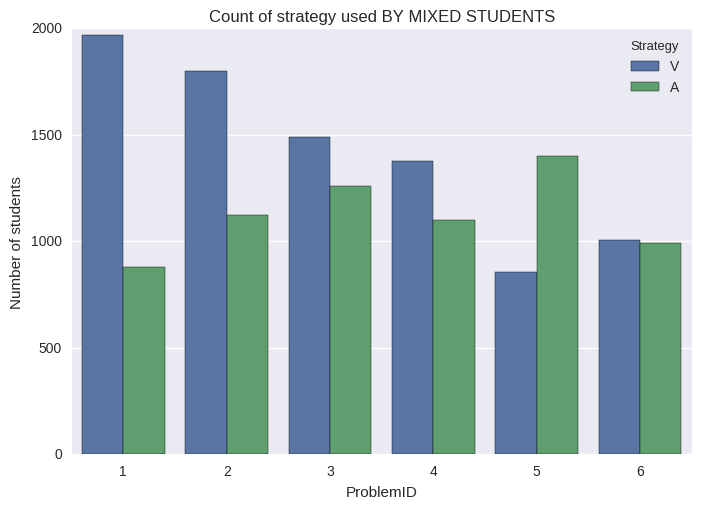

In [6]:
d = pd.DataFrame(rdd
 .map(lambda x: { 'ProblemID': utils.reOrderProblemID(x['ProblemID']), 'Strategy': getStrategy(x['Features']) })
 .collect()
)

sns.countplot(x='ProblemID', hue='Strategy', data=d)

plt.title('Count of strategy used BY MIXED STUDENTS')
plt.ylabel('Number of students')
plt.xlabel('ProblemID')
plt.show()

In [7]:
def concatProblemList(l):
    D = { 'Strategy': 'D', 'Data': -1 }
    p = { 1: D, 2: D, 3: D, 4: D, 5: D, 6: D}
    for item in l:
        p[item['ProblemID']] = { 'Strategy': item['Strategy'], 'Data': item['Data'] }
    return p

def test(feature, status):
    d = pd.DataFrame(rdd
     .map(lambda x: (x['StudentID'], {
        'ProblemID': utils.reOrderProblemID(x['ProblemID']), 
        'Strategy': getStrategy(x['Features']),
        'Data': x['Features'][feature]
     }))
     .groupByKey()
     .map(lambda x: concatProblemList(x[1]))
     .flatMap(lambda x: (
        [{'Data': x[i]['Data'], 'Strategy': x[i+1]['Strategy']} for i in range(1,6) if (not x[i]['Data'] == -1)] 
        if status == 'previous' else
        [{'Data': x[i]['Data'], 'Strategy': x[i]['Strategy']} for i in range(1,7) if (not x[i]['Data'] == -1)]
     ))
     .collect()
    )

    print(stats.f_oneway(
        d[d.Strategy=='V'].Data.tolist(),
        d[d.Strategy=='A'].Data.tolist(),
        d[d.Strategy=='D'].Data.tolist()
    ))

    print(stats.f_oneway(
        d[d.Strategy=='V'].Data.tolist(),
        d[d.Strategy=='A'].Data.tolist(),
    ))

    print(
        '\nV\t', d[d.Strategy=='V'].Data.mean(),
        '\nA\t', d[d.Strategy=='A'].Data.mean(),
        '\nD\t', d[d.Strategy=='D'].Data.mean(),
    )

    sns.boxplot(x='Data', y='Strategy', data=d)

    plt.title('Strategy choice from ' + feature)
    plt.ylabel('Current strategy')
    plt.xlabel(feature)
    plt.show()
    

def test2(feature, status):
    d = pd.DataFrame(rdd
     .map(lambda x: (x['StudentID'], {
        'ProblemID': utils.reOrderProblemID(x['ProblemID']), 
        'Strategy': getStrategy(x['Features']),
        'Data': int(x['Features'][feature])
     }))
     .groupByKey()
     .map(lambda x: concatProblemList(x[1]))
     .flatMap(lambda x: (
        [{'Data': x[i]['Data'], 'Strategy': x[i+1]['Strategy']} for i in range(1,6) if (not x[i]['Data'] == -1)] 
        if status == 'previous' else
        [{'Data': x[i]['Data'], 'Strategy': x[i]['Strategy']} for i in range(1,7) if (not x[i]['Data'] == -1)]
     ))
     .collect()
    )

    #np.histogram(d['Data'], bins=10)
    
    for i in range(11):
        plt.figure()
        sns.countplot(x='Data', hue='Strategy', data=d[d.Data==i])

    plt.title('Strategy choice from ' + feature)
    plt.ylabel('Current strategy')
    plt.xlabel(feature)
    plt.show()

# Strategy vs. previous first/last grade

F_onewayResult(statistic=98.585999400945042, pvalue=3.1627220066978186e-43)
F_onewayResult(statistic=4.4288695289782982, pvalue=0.035356518554927684)

V	 9.062195612268612 
A	 8.995611045237572 
D	 8.266049304247165


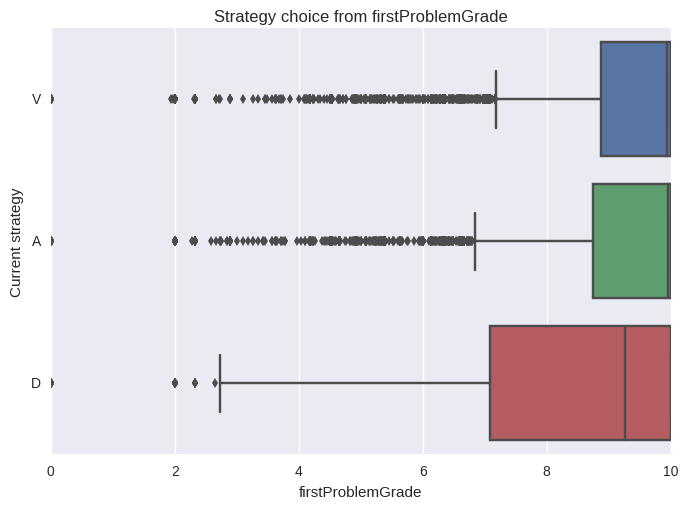

In [8]:
test('firstProblemGrade', 'previous')

F_onewayResult(statistic=314.75234795895415, pvalue=2.8341587865767616e-134)
F_onewayResult(statistic=4.6954032240269168, pvalue=0.030262891076924682)

V	 9.715564945829783 
A	 9.680562690709905 
D	 8.918564172750878


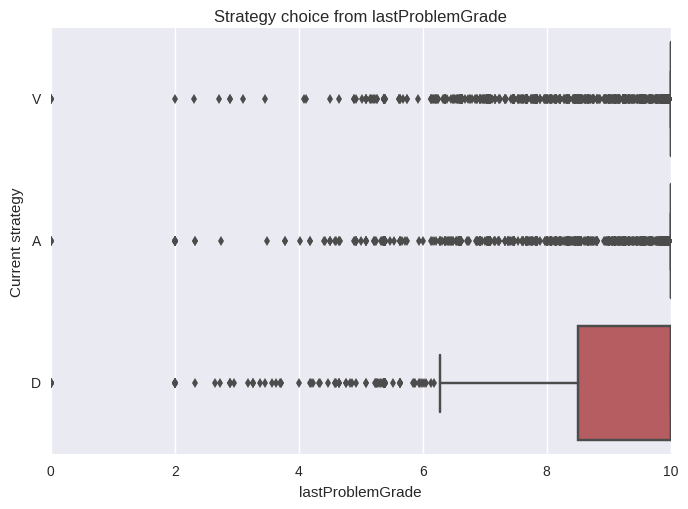

In [9]:
test('lastProblemGrade', 'previous')

# Strategy vs. previous number of submission

F_onewayResult(statistic=9.7542504453956553, pvalue=5.8465294172622612e-05)
F_onewayResult(statistic=8.3066874465191685, pvalue=0.0039569016026623841)

V	 1.8131455399061034 
A	 1.7480218041146474 
D	 1.6576040781648258


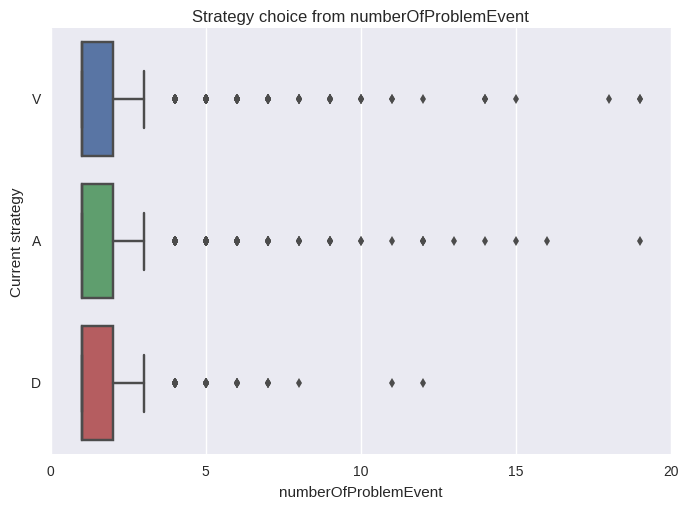

In [10]:
test('numberOfProblemEvent', 'previous')

# Strategy vs. current time until deadline

F_onewayResult(statistic=nan, pvalue=nan)
F_onewayResult(statistic=2155.8916042564897, pvalue=0.0)

V	 11.046686513192293 
A	 7.842015912939121 
D	 nan


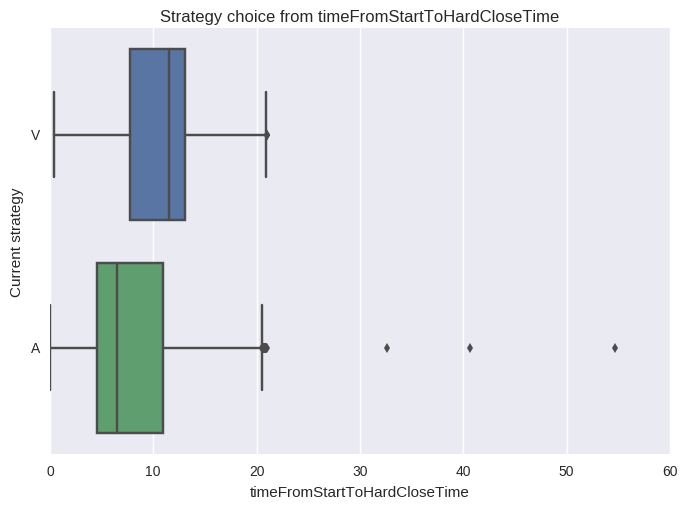

In [11]:
test('timeFromStartToHardCloseTime', 'current')

F_onewayResult(statistic=nan, pvalue=nan)
F_onewayResult(statistic=56.047345576887963, pvalue=7.4611355249619495e-14)

V	 7.350798314060465 
A	 7.842015912939121 
D	 nan


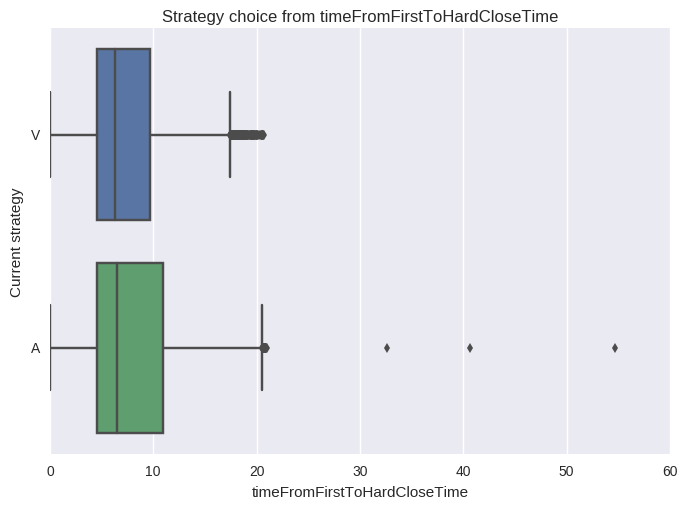

In [12]:
test('timeFromFirstToHardCloseTime', 'current')

F_onewayResult(statistic=nan, pvalue=nan)
F_onewayResult(statistic=54.128606597209874, pvalue=1.9735064507119432e-13)

V	 7.120097672431087 
A	 7.596285516773226 
D	 nan


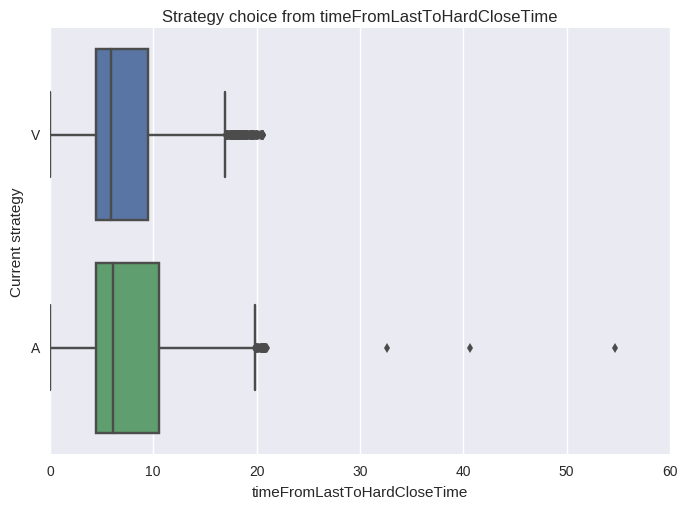

In [13]:
test('timeFromLastToHardCloseTime', 'current')

# Strategy vs. difficulty

# Strategy vs. previous strategy

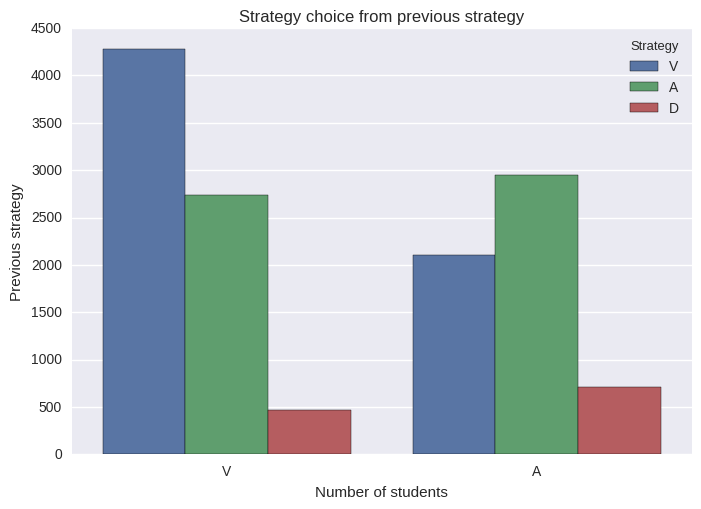

In [14]:
d = pd.DataFrame(rdd
 .map(lambda x: (x['StudentID'], {
    'ProblemID': utils.reOrderProblemID(x['ProblemID']), 
    'Strategy': getStrategy(x['Features']),
    'Data': getStrategy(x['Features'])
 }))
 .groupByKey()
 .map(lambda x: concatProblemList(x[1]))
 .flatMap(lambda x: [{'Data': x[i]['Data'], 'Strategy': x[i+1]['Strategy']} for i in range(1,6) if (not x[i]['Data'] == -1)])
 .collect()
)

sns.countplot(x='Data', hue='Strategy', data=d)

plt.title('Strategy choice from previous strategy')
plt.ylabel('Previous strategy')
plt.xlabel('Number of students')
plt.show()